# Example 2: Optical Waveguides

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm import tqdm

from pydmd import BOPDMD, SparseBOPDMD
from pydmd.plotter import plot_summary
from pydmd.sbopdmd_utils import *

def error(actual, truth):
    """
    Compute relative error.
    """
    return np.linalg.norm(actual - truth) / np.linalg.norm(truth)

import warnings
warnings.filterwarnings("ignore")

## Part 1: Define the eigenfunctions and eigenvalues
$$
\tfrac{1}{2} v_n''(x) - n_0(x) v_n(x) = \lambda_n v_n(x)
$$
$$
n_0(x) = 
\begin{cases}
-1 & |x| < 5 \\ 
\:\;\; 0 & \text{else}
\end{cases}
$$

In [2]:
def n_0(x, V0, a):
    """
    The index of refraction profile.
    """
    n0_array = np.zeros(len(x))
    n0_array[np.abs(x) < a] = -V0

    return n0_array


def compute_true_modes_bound(x, V0, a, n_xi=1e+8):
    """
    x = x-values on which to evaluate the eigenfunctions
    V0 = depth of the square well, which is [0, -V0]
    a = width of the square well, which lies on [-a, a]
    n_xi = number of xi values to use on the domain [0, r]
    """
    # Define xi domain and eta values for alpha/beta condition.
    r = np.sqrt(2 * V0 * a ** 2)
    xi = np.linspace(0, r, int(n_xi)) # [0, r]
    eta = np.sqrt(r ** 2 - xi ** 2)

    # Define eta conditions for even and odd states.
    eta_even = np.multiply(xi, np.tan(xi))
    eta_odd = -np.multiply(xi, 1 / np.tan(xi))

    # Find condition intersections.
    intersect_even = np.argwhere(np.diff(np.sign(eta - eta_even))).flatten()[::2]
    intersect_odd = np.argwhere(np.diff(np.sign(eta - eta_odd))).flatten()[1::2]

    # Condition intersections yield valid energy levels.
    E_even = -(0.5 / (a ** 2)) * (eta[intersect_even] ** 2)
    E_odd = -(0.5 / (a ** 2)) * (eta[intersect_odd] ** 2)

    # Use energies to compute alpha and beta values.
    alpha_even = np.sqrt(2 * (V0 + E_even))
    alpha_odd = np.sqrt(2 * (V0 + E_odd))
    beta_even = np.sqrt(-2 * E_even)
    beta_odd = np.sqrt(-2 * E_odd)

    # Use alpha and beta values to define the eigenvector functions.
    idx_z = nx // 2
    idx_a = np.where(x >= a)[0][0]
    V_bound = np.empty((nx, len(E_even) + len(E_odd)))

    # Compute the even fucntions.
    for i, (alpha, beta) in enumerate(zip(alpha_even, beta_even)):
        V_bound[idx_z:idx_a, 2 * i] = np.cos(alpha * x[idx_z:idx_a])
        V_bound[idx_a:, 2 * i] = np.cos(alpha * a) * np.exp(beta * (a - x[idx_a:]))
        # v(x) is even
        V_bound[:idx_z, 2 * i] = np.flip(V_bound[idx_z:, 2 * i])
        # normalize v(x)
        V_bound[:, 2 * i] /= np.sqrt(np.sum(V_bound[:, 2 * i] ** 2))

    # Compute the odd fucntions.
    for i, (alpha, beta) in enumerate(zip(alpha_odd, beta_odd)):
        V_bound[idx_z:idx_a, 2 * i + 1] = np.sin(alpha * x[idx_z:idx_a])
        V_bound[idx_a:, 2 * i + 1] = np.sin(alpha * a) * np.exp(beta * (a - x[idx_a:]))
        # v(x) is odd
        V_bound[:idx_z, 2 * i + 1] = -np.flip(V_bound[idx_z:, 2 * i + 1])
        # normalize v(x)
        V_bound[:, 2 * i + 1] /= np.sqrt(np.sum(V_bound[:, 2 * i + 1] ** 2))

    # Store the corresponding eigenvalues.
    E_bound = np.empty(len(E_even) + len(E_odd))
    E_bound[::2] = E_even
    E_bound[1::2] = E_odd

    return V_bound, E_bound


def compute_true_modes_scatter(E, x, V0, a):
    """
    E = non-negative energies for which to compute modes, array-like
    x = x-values on which to evaluate the eigenfunctions
    V0 = depth of the square well, which is [0, -V0]
    a = width of the square well, which lies on [-a, a]
    """
    E = np.array(E)

    # Ensure that all requested energies are positive.
    if np.any(E <= 0):
        raise ValueError("Energy values must be positive.")

    # Compute commonly-used quantities:
    alpha = np.sqrt(2 * (V0 + E))
    beta = np.sqrt(2 * E)
    L = 2 * a

    # Compute the coefficients of v(x) expressions:
    k1 = 1j * (alpha ** 2 + beta ** 2) / (2 * alpha * beta)
    k2 = 1j * (alpha ** 2 - beta ** 2) / (2 * alpha * beta)
    k3 = 1j * (beta / alpha)

    A_coeffs = np.exp(1j * L * beta) * (np.cos(L * alpha) - k1 * np.sin(L * alpha))
    B_coeffs = k2 * np.sin(L * alpha)
    C_coeffs = np.exp(1j * a * beta) * (np.sin(a * alpha) + k3 * np.cos(a * alpha))
    D_coeffs = np.exp(1j * a * beta) * (np.cos(a * alpha) - k3 * np.sin(a * alpha))

    idx_a1 = np.where(x >= -a)[0][0]
    idx_a2 = np.where(x >= a)[0][0]

    # Define the eigenvector functions.
    V_scatter = np.empty((nx, len(E)), dtype="complex")

    # Left of the potential well.
    V_scatter[:idx_a1, :] = A_coeffs * np.exp(1j * np.outer(x[:idx_a1], beta))
    V_scatter[:idx_a1, :] += B_coeffs * np.exp(-1j * np.outer(x[:idx_a1], beta))

    # Inside the potential well.
    V_scatter[idx_a1:idx_a2, :] = C_coeffs * np.sin(np.outer(x[idx_a1:idx_a2], alpha))
    V_scatter[idx_a1:idx_a2, :] += D_coeffs * np.cos(np.outer(x[idx_a1:idx_a2], alpha))

    # Right of the potential well.
    V_scatter[idx_a2:, :] = np.exp(1j * np.outer(x[idx_a2:], beta))

    # Normalize each eigenfunction.
    V_scatter = V_scatter.dot(np.diag(1 / np.linalg.norm(V_scatter, 2, axis=0)))

    return V_scatter


Space Discretization: [-25.0, 25.0], dx = 0.1


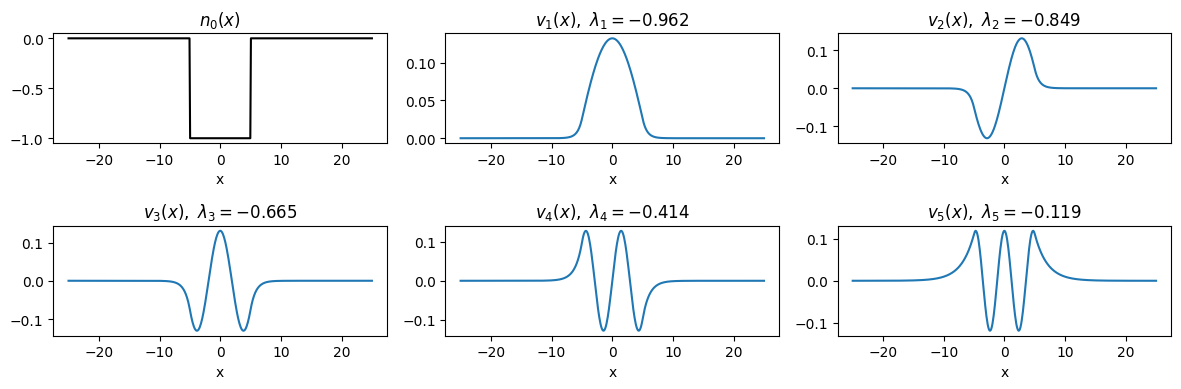

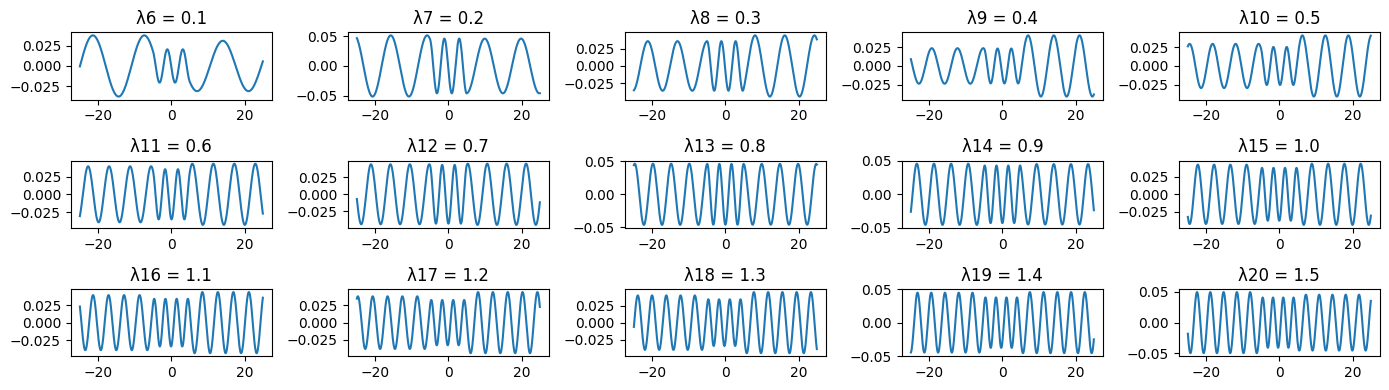

In [3]:
# Parameters of the potential well:
V0 = 1
a = 5

# Define the spatial grid (for computing ground truth spectrum).
nx = 500
x = np.linspace(-25, 25, nx)
dx = x[1] - x[0]
print(f"Space Discretization: [{x[0]}, {x[-1]}], dx = {np.round(dx, decimals=3)}")

# Compute the index of refraction profile.
n0 = n_0(x, V0, a)

# Compute the bound states.
V_bound, E_bound = compute_true_modes_bound(x, V0, a)

# Compute the scattering states.
E_scatter = np.linspace(0.1, 50, 500)
V_scatter = compute_true_modes_scatter(E_scatter, x, V0, a)

# Gather the eigenvalues and eigenfunctions.
eigs = np.concatenate([E_bound, E_scatter])
V = np.concatenate([V_bound, V_scatter], axis=1)

# Plot index of refraction and the bound eigenfunctions.
plt.figure(figsize=(12, 4))
plt.subplot(2, 3, 1)
plt.plot(x, n0, c="k")
plt.title("$n_0(x)$")
plt.xlabel("x")
for i, (v, _lambda) in enumerate(zip(V.T[:5], eigs[:5])):
    plt.subplot(2, 3, i + 2)
    plt.plot(x, v)
    plt.title(f"$v_{i+1}(x),$ $\lambda_{i+1} = {np.round(_lambda, decimals=3)}$")
    plt.xlabel("x")
plt.tight_layout()
plt.show()

# Plot the next 15 modes (NOT localized to the well).
plt.figure(figsize=(14, 4))
for i, (v, _lambda) in enumerate(zip(V.T[5:20], eigs[5:20])):
    plt.subplot(3, 5, i + 1)
    plt.plot(x, v)
    plt.title(f"λ{i+6} = {np.round(_lambda, decimals=3)}")
plt.tight_layout()
plt.show()

## Part 2: Build data set
$$
iu_t + \tfrac{1}{2}u_{xx} - n_0(x) u = 0
$$

Time Discretization: [0, 199], dt = 1


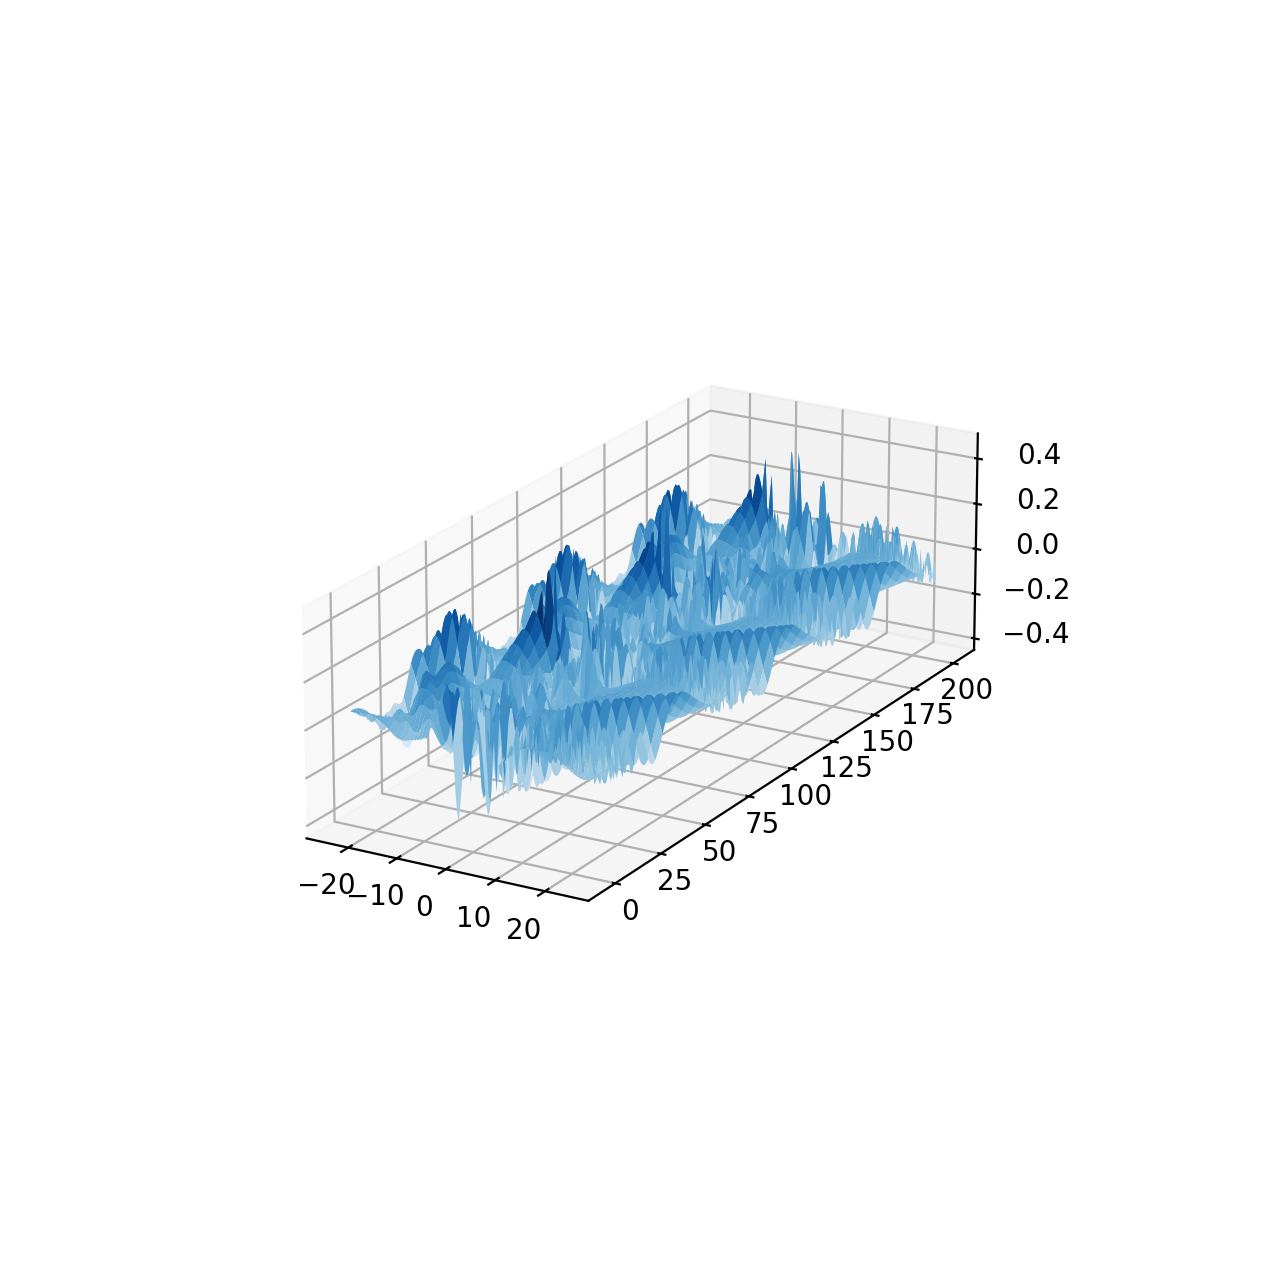

In [4]:
# Define the temporal grid.
t = np.arange(0, 200, 1)
dt = t[1] - t[0]
print(f"Time Discretization: [{t[0]}, {t[-1]}], dt = {np.round(dt, decimals=3)}")

# Define the amplitudes of the modes.
b = np.empty(len(eigs))
b[:len(E_bound)] = 0.5 # discrete amplitudes
b[len(E_bound):] = 0.2 / E_scatter # continuous amplitudes

# Build the data set using the true spatiotemporal modes.
U = np.linalg.multi_dot([V, np.diag(b), np.exp(-1j * np.outer(eigs, t))])

# Plot the data as a surface plot in time and space.
plt.style.use("default")
fig = plt.figure(figsize=(8, 8), dpi=200)
ax = fig.add_subplot(111, projection="3d")

# Define the space, time mesh.
xgrid, tgrid = np.meshgrid(x, t)

# Make the surface plot.
ax.plot_surface(xgrid, tgrid, U.T, cmap="Blues")

# 3-D plot formatting.
label_size = 14
tick_size = 10
ax.view_init(elev=20, azim=-60)
# ax.set_title("u(x, t)", fontsize=label_size)
# ax.set_xlabel("x (space)", labelpad=15, fontsize=label_size)
# ax.set_ylabel("t (time)", labelpad=20, fontsize=label_size)
# ax.set_zlabel("u", labelpad=20, fontsize=label_size)
ax.tick_params(axis="x", which="major", labelsize=tick_size)
ax.tick_params(axis="y", which="major", labelsize=tick_size)
ax.tick_params(axis="z", which="major", labelsize=tick_size, pad=15)
# ax.axis("off")

# Stretch the time axis.
def short_proj():
    scale = np.diag([1.0, 2.5, 1.0, 1.0])
    scale /= scale.max()
    scale[3, 3] = 1.0
    return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj = short_proj
plt.show()

## Part 4: Apply DMD

In [5]:
# Helper function for plotting all modes of a given DMD model.
# This version plots the modes on hierarchical levels that denote energy.
# Modes are also scaled by their amplitudes and plotted against n0(x).
def plot_all_modes_levels(
    model,
    figsize=(6, 12),
    dpi=100,
    DMD_c="r",
    n_true=None,
    index_modes=None,
    filename=None,
    ylim=None,
):
    mode_order = np.argsort(-np.abs(model.amplitudes))
    lead_eigs = model.eigs[mode_order]
    lead_modes = model.modes[:, mode_order]
    lead_amps = model.amplitudes[mode_order]

    if n_true is None:
        n_true = len(eigs)

    if index_modes is None:
        index_modes = np.arange(n_true)

    # bound_colors = [c["color"] for c in plt.rcParams["axes.prop_cycle"]]
    plt.figure(figsize=figsize, dpi=dpi)

    # Plot the index of refraction profile (i.e. potential well).
    plt.plot(x, n0, lw=3, c="k")

    # Plot the true modes.
    for i in range(n_true):
        plt.plot(x, b[i] * V[:, i] + eigs[i], c="gray", lw=3)

    # Plot the DMD modes.
    for i in index_modes:
        plt.plot(x, lead_amps[i] * lead_modes[:, i] - lead_eigs[i].imag, c=DMD_c, lw=2)

    if ylim is not None:
        plt.ylim(ylim)

    plt.axis("off")
    if filename is None:
        plt.show()
    else:
        plt.savefig(f"{filename}.png", transparent=True)

# Define the data to be passed to DMD.
rng = np.random.default_rng(1234)
U_noisy = U + 0.15 * rng.standard_normal(U.shape)

## Optimized DMD

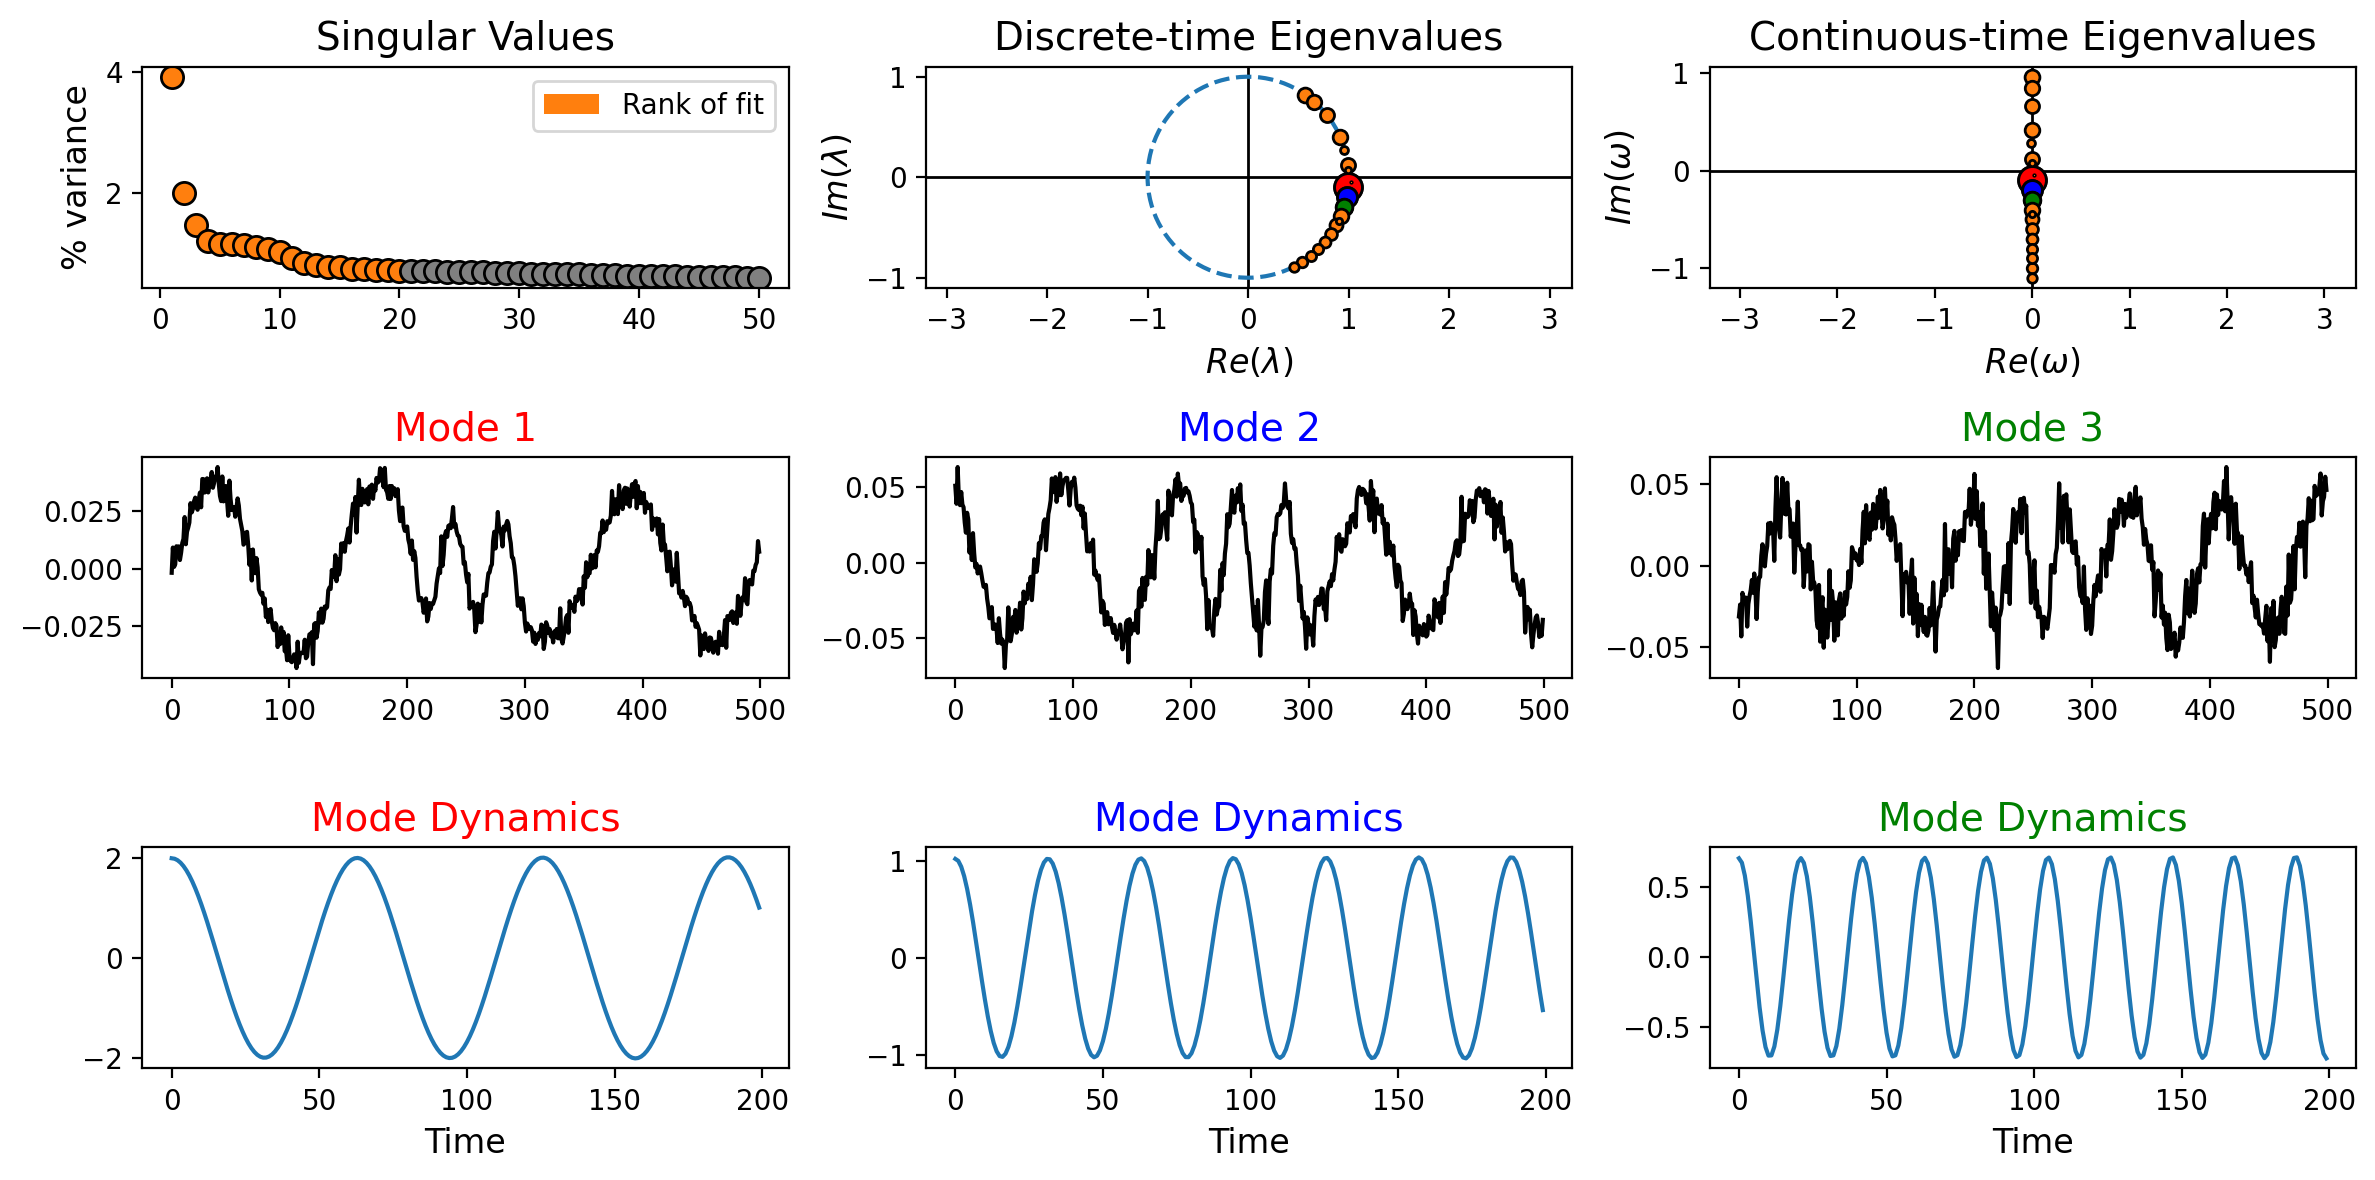

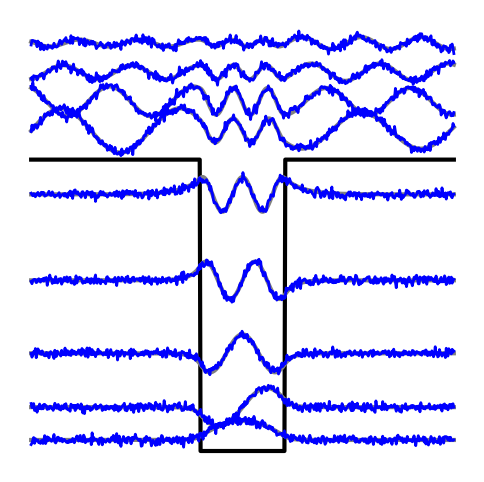

DMD results:
Model Error = 0.39619524423795466


In [6]:
optdmd = BOPDMD(svd_rank=20)
optdmd.fit(U_noisy, t)
plot_summary(optdmd, figsize=(12, 6))
plot_all_modes_levels(optdmd, figsize=(6, 6), DMD_c="b", n_true=9)
# plot_all_modes_levels(optdmd, figsize=(5, 9), DMD_c="b", n_true=9, dpi=200, ylim=[-1.1, 0.6], filename="wave_dmd")

print("DMD results:")
print(f"Model Error = {error(optdmd.reconstructed_data, U)}")

## Sparse-mode DMD (FISTA)

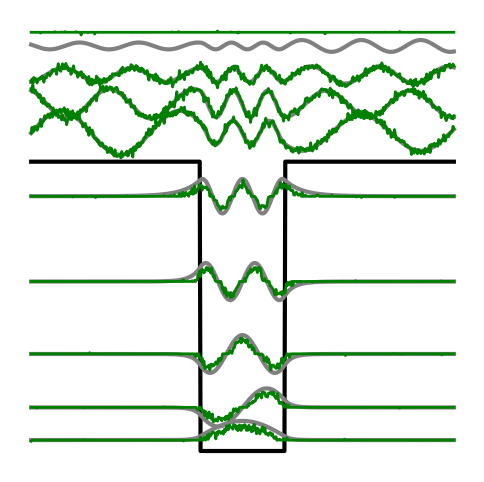

Sparse-mode DMD (FISTA l1 w/ projection) results:
Model Error = 0.44065555575878546
17 variable projection iterations.
43.1764705882353 mode update iterations on average.


In [7]:
sp_optdmd_fista = SparseBOPDMD(
    svd_rank=20,
    SR3_step=0,
    mode_regularizer="l1",
    regularizer_params={"lambda": 4.0},
    eig_constraints={"imag"},
    index_global="auto",
    varpro_opts_dict={
        # "verbose": True,
        "maxiter": 100,
    },
)
sp_optdmd_fista.fit(U_noisy, t)
index_modes = np.arange(9)
index_modes[-1] = 13
plot_all_modes_levels(sp_optdmd_fista, figsize=(6, 6), DMD_c="g", n_true=9, index_modes=index_modes)
# plot_all_modes_levels(sp_optdmd_fista, figsize=(5, 9), DMD_c="g", n_true=9, index_modes=index_modes, dpi=200, ylim=[-1.1, 0.6], filename="wave_dmd_fista")

print("Sparse-mode DMD (FISTA l1 w/ projection) results:")
print(f"Model Error = {error(sp_optdmd_fista.reconstructed_data, U)}")
print(f"{len(sp_optdmd_fista.operator._obj_history)} variable projection iterations.")
avg_iter = np.average([len(x) for x in sp_optdmd_fista.operator._obj_history])
print(f"{avg_iter} mode update iterations on average.")

## Sparse-mode DMD (SR3)

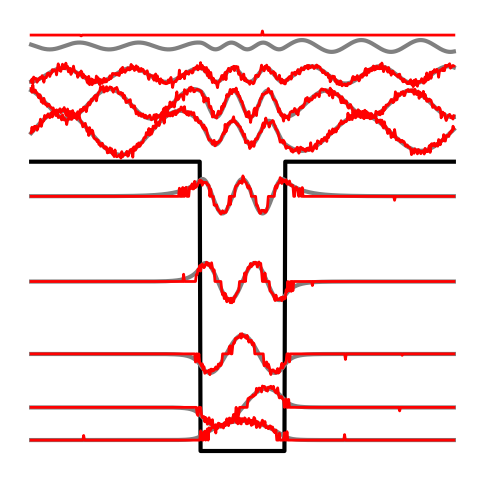

Sparse-mode DMD (SR3) results:
Model Error = 0.4379116871501765
9 variable projection iterations.
4.888888888888889 mode update iterations on average.


In [8]:
sp_optdmd_sr3 = SparseBOPDMD(
    svd_rank=20,
    SR3_step=1,
    mode_regularizer="l1",
    regularizer_params={"lambda": 0.025},
    apply_debias=True,
    index_global="auto",
    varpro_opts_dict={
        # "verbose": True,
        "maxiter": 100,
    },
)
sp_optdmd_sr3.fit(U_noisy, t)
index_modes = np.arange(9)
index_modes[3] = 16
plot_all_modes_levels(sp_optdmd_sr3, figsize=(6, 6), DMD_c="r", n_true=9, index_modes=index_modes)
# plot_all_modes_levels(sp_optdmd_sr3, figsize=(5, 9), DMD_c="r", n_true=9, index_modes=index_modes, dpi=200, ylim=[-1.1, 0.6], filename="wave_dmd_sr3")

print("Sparse-mode DMD (SR3) results:")
print(f"Model Error = {error(sp_optdmd_sr3.reconstructed_data, U)}")
print(f"{len(sp_optdmd_sr3.operator._obj_history)} variable projection iterations.")
avg_iter = np.average([len(x) for x in sp_optdmd_sr3.operator._obj_history])
print(f"{avg_iter} mode update iterations on average.")

### Figures:

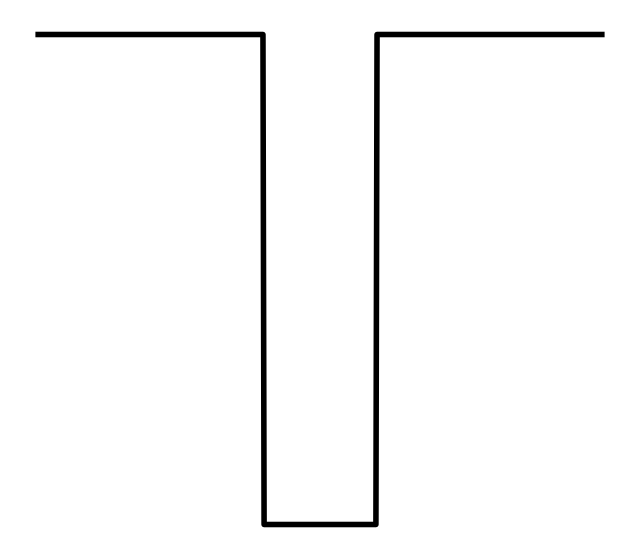

In [9]:
plt.figure(figsize=(8, 7), dpi=100)
plt.plot(x, n0, lw=4, c="k")
plt.axis("off")
plt.show()
# plt.savefig("figures/figure-waveguides/n0.png", transparent=True)

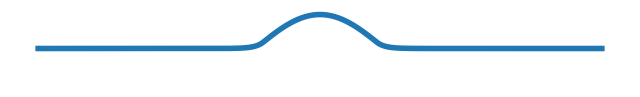

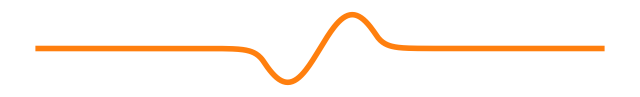

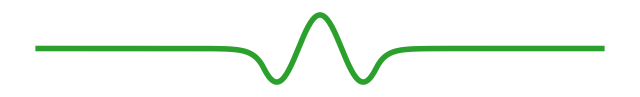

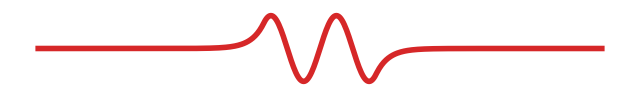

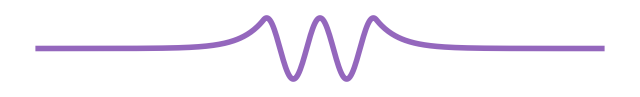

In [10]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

for i in range(5):
    plt.figure(figsize=(8, 1), dpi=100)
    plt.plot(V[:, i], lw=4, c=colors[i])
    plt.ylim([-0.15, 0.15])
    plt.axis("off")
    plt.show()
    # plt.savefig(f"figures/figure-waveguides/v{i+1}.png", transparent=True)

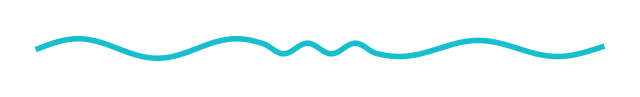

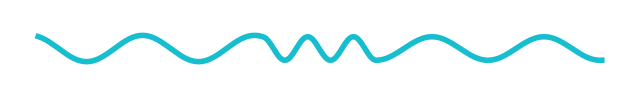

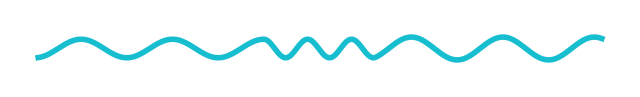

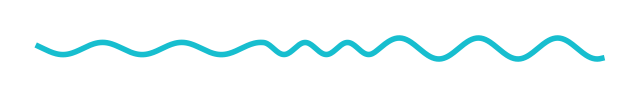

In [11]:
V_scatter_plot = compute_true_modes_scatter([0.1, 0.2, 0.3, 0.4], x, V0, a)

for i in range(V_scatter_plot.shape[1]):
    plt.figure(figsize=(8, 1), dpi=100)
    # plt.axhline(y=0, c="k", lw=1)
    plt.plot(V_scatter_plot[:, i], lw=4, c="tab:cyan")
    plt.ylim([-0.15, 0.15])
    plt.axis("off")
    plt.show()
    # plt.savefig(f"figures/figure-waveguides/v_scatter{i+1}.png", transparent=True)

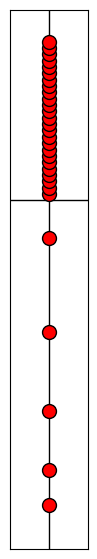

In [12]:
E_scatter_plot = np.arange(0.02, 0.52, 0.02)

plt.figure(figsize=(1, 7), dpi=100)
plt.axhline(y=0, lw=1, c="k")
plt.axvline(x=0, lw=1, c="k")
plt.plot(np.zeros(len(E_bound)), E_bound, "o", c="r", mec="k", ms=10)
plt.plot(np.zeros(len(E_scatter_plot)), E_scatter_plot, "o", c="r", mec="k", ms=10)
plt.ylim([-1.1, 0.6])
plt.xticks([])
plt.yticks([])
plt.show()
# plt.savefig("figures/figure-waveguides/eigs.png", transparent=True)